In [1]:
import pandas as pd
import numpy as np
import glob, os, sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style = 'whitegrid', font_scale = 1.3)

In [2]:
sys.path.append('..')
from modules.plotting_metrics import PlotMetric

In [3]:
# Read the MDS resutls
import pickle
path_mds_obj = os.path.join('..', 'data', 'trajectory_analysis', 'cMDS_Pisani_402_obj.pyobj')
#
with open(path_mds_obj, 'rb') as f:
    mds_pisani_402 = pickle.load(f)

In [26]:
# Helper functions
%run ./helper_functions_S6.ipynb

In [5]:
# Dictionary of docking results
# notebook helper_functions does the trick
scores_dic = get_docking_scores_dict()

In [6]:
bc_csar, bc_csar_auc = get_best_conformation('CSAR', 'Dk_sc')

print(F'Best conf. in CSAR:', bc_csar, ', AUC:', bc_csar_auc)

Best conf. in CSAR: 2vv9 , AUC: 0.8486425339366516


In [7]:
bc_dud, bc_dud_auc = get_best_conformation('DUD', 'Dk_sc')

print(F'Best conf. in DUD:', bc_dud, ', AUC:', bc_dud_auc)

Best conf. in DUD: 3le6 , AUC: 0.6750040180006429


In [8]:
bc_dekois, bc_dekois_auc = get_best_conformation('DEKOIS', 'Dk_sc')

print(F'Best conf. in DEKOIS:', bc_dekois, ', AUC:', bc_dekois_auc)

Best conf. in DEKOIS: 2iw6 , AUC: 0.7904375


#### Initialization of some varaibles

In [9]:
N_REPS = 30 # Number of replicas to use in random picking
MIN_CONFS = 1
MAX_CONFS = 402
INTERVAL = 1
# Output directory to save the results of each assay
output_dir = '../data/ml_evaluations/'

# Database to be used for training
train_key = 'CSAR'
# Dictionary of scores to be evaluated
scores_dic
# List of type of scores (docking score or ligand efficiency score)
score_types = ['Dk_sc']
# List of datasets to be used as test
test_keys = ['DUD', 'DEKOIS']

### Get the medoids with k-means for k in range 1 to 402

- `random_state = 0` is used in order to get the same k conformations to evaluate all the machine learning models.

In [10]:
%%time
# Precomputed clustering with k-means for k in range 1 to 402
# Save to a file to avoid recompute it each time
file_list_of_confs_per_k =  F'{output_dir}/\
list_of_confs_per_k_pisani_mds.json'

if os.path.isfile(file_list_of_confs_per_k):
    df_confs_per_k = pd.read_json(file_list_of_confs_per_k)
else:
    list_of_confs_per_k = []
    _X = mds_pisani_402[0]

    for n_clusters in range(1, 402 + 1):
        confs_idx = get_medoids_idx(_X, n_clusters = n_clusters, random_state = 0)
        list_of_confs_per_k.append(confs_idx)
        df_confs_per_k = pd.DataFrame({'list_of_confs_pisani': list_of_confs_per_k})
        df_confs_per_k.to_json(file_list_of_confs_per_k)

df_confs_per_k.sort_index(inplace=True)

CPU times: user 14 ms, sys: 4.43 ms, total: 18.5 ms
Wall time: 17.5 ms


## Linear SVM

In [11]:
from sklearn.svm import SVC

#### Random picking

In [12]:
ml_model = SVC
model_name = 'LinearSVC'
# hyperparameters
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)

lSVC_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys, n_reps = 30,
                  **hyparms)

#### K-means picking

In [13]:
ml_model = SVC
model_name = 'LinearSVC'
# hyperparameters
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)

lSVC_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                  **hyparms)

<h4>Visualization: <span class="text-muted">Linear SVM Results</span></h4>

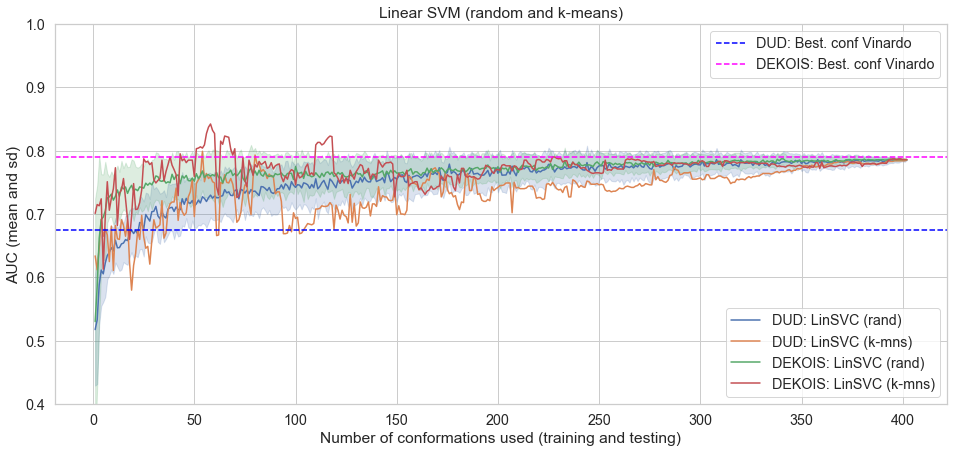

In [14]:
# Results
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {'LinSVC (rand)': lSVC_rd_dict, 'LinSVC (k-mns)': lSVC_km_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax)
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Linear SVM (random and k-means)')
plt.show()

## Radial Basis Function SVM

#### Random picking

In [15]:
ml_model = SVC
model_name = 'rbfSVC'
# hyperparameters
hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)

rbfSVC_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys, n_reps = 30,
                  **hyparms)

#### K-means picking

In [16]:
ml_model = SVC
model_name = 'rbfSVC'
# hyperparameters
hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)

rbfSVC_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                  **hyparms)

<h4>Visualization: <span class="text-muted">Linear SVM Results</span></h4>

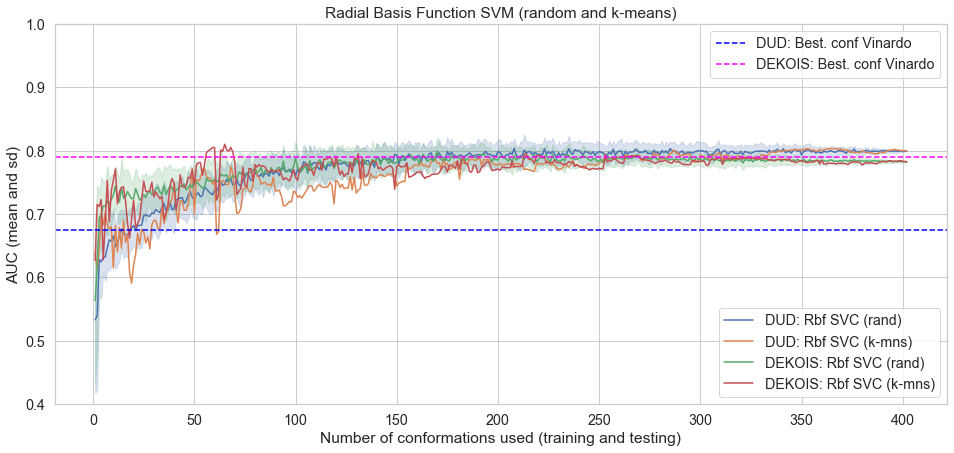

In [17]:
# Results
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {'Rbf SVC (rand)': rbfSVC_rd_dict, 'Rbf SVC (k-mns)': rbfSVC_km_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax)
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Radial Basis Function SVM (random and k-means)')
plt.show()

## Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

#### Random picking

In [19]:
ml_model = LogisticRegression
model_name = 'LogRg'
# hyperparameters
hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs')

logRG_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, 
                                  train_key, test_keys, n_reps = 30,
                                  **hyparms)

#### K-means picking

In [20]:
ml_model = LogisticRegression
model_name = 'LogRg'
# hyperparameters
hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs')

logRG_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                  **hyparms)

<h4>Visualization: <span class="text-muted">Linear SVM Results</span></h4>

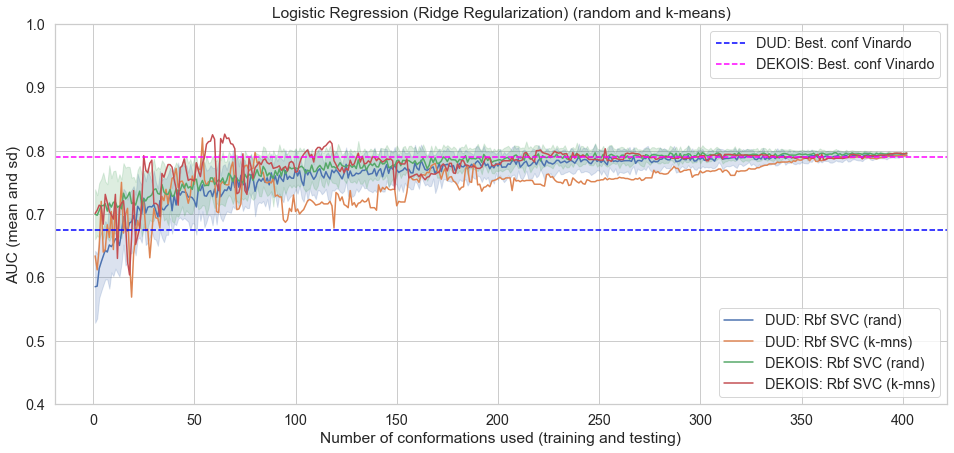

In [21]:
# Results
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {'Rbf SVC (rand)': logRG_rd_dict, 'Rbf SVC (k-mns)': logRG_km_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax)
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Logistic Regression (Ridge Regularization) (random and k-means)')
plt.show()

### Decision Tree Classifier

In [22]:
from sklearn.tree import DecisionTreeClassifier

In [23]:
%%time
ml_model = DecisionTreeClassifier
model_name = 'Tree'
# hyperparameters
hyparms = dict(criterion = 'gini', max_depth = 2)

dTree_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, 
                                  train_key, test_keys, n_reps = 30,
                                  **hyparms)

CPU times: user 2.96 ms, sys: 0 ns, total: 2.96 ms
Wall time: 1.83 ms


In [24]:
%%time
ml_model = DecisionTreeClassifier
model_name = 'Tree'
# hyperparameters
hyparms = dict(criterion = 'gini', max_depth = 2)

dTree_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                  **hyparms)

CPU times: user 0 ns, sys: 2.17 ms, total: 2.17 ms
Wall time: 1.22 ms


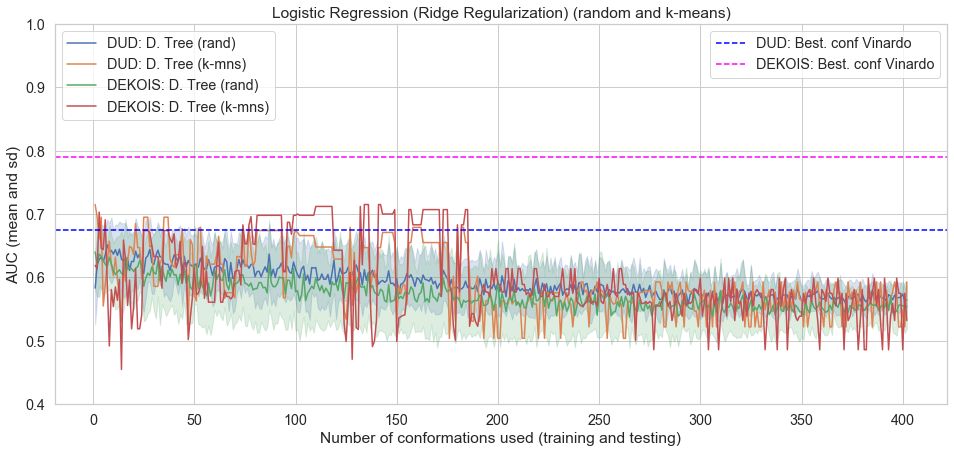

In [27]:
# Results
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {'D. Tree (rand)': dTree_rd_dict, 'D. Tree (k-mns)': dTree_km_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax, legend_position = 'upper left')
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Decision Tree Classifier (random and k-means)')
plt.show()